In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## data preprocessing

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 받은 DataFrame을 복사한 뒤 큰 의미없는 Time 컬럼만 삭제하고 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [26]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수(7 : 3)
def get_train_test_dataset(df=None):
    # 인자로 입력된 dataframe의 사전 데이터 가공이 완료된 복사 dataframe반환
    df_copy = get_preprocessed_df(df)
    # dataframe의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반(불균형 데이터일때) 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 셋 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test= get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


레이블 1의 값이 약 0.172%, 0.173%로 큰 차이없이 잘 분할됨을 확인할 수 있다. 이제 모델을 만들어 볼 것이다. 
1. 로지스틱 회귀 모델로 신용카드 사기 여부 예측
2. LightGBM 기반 모델로 예측 성능 변화 관찰

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# get_clf_eval(함수를 이용해 평가 수행)
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def get_clf_eval(y_test,preds,pred_probs):
    confusion = confusion_matrix(y_test,preds)
    accuracy = accuracy_score(y_test,preds)
    precision = precision_score(y_test,preds)
    recall = recall_score(y_test,preds)
    f1= f1_score(y_test,preds)
    
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test,pred_probs)
    print('오차행렬')
    print(confusion)
    
    #ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85280    15]
 [   54    94]]
정확도: 0.9992, 정밀도: 0.8624, 재현율 : 0.6351, F1: 0.7315, AUC:0.9596


## LightGBM

In [7]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 셋을 입력받아 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

>  본 데이터 셋은 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_averate=False로 파라미터를 설정해야한다!

In [8]:
# 별도의 테스트 데이터 셋에서 예측 평가 수행
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False) #n_jobs=-1은 모든 CPU 코어를 이용
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율 : 0.7568, F1: 0.8421, AUC:0.9797


재현율이 0.7568, ROC-AUC 0.97로 앞의 로지스틱 회귀보다 높은 수치를 나타낸다.

## data distribution transformation
이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해 볼것이다. 먼저 creditcard.csv의 중요 피처 값의 분포도를 살핀다. logistic regression과 같은 대부분의 선형 모델은 중요 피처들의 값이 **정규 분포 형태**를 유지하는 것을 선호한다. Amount피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. 

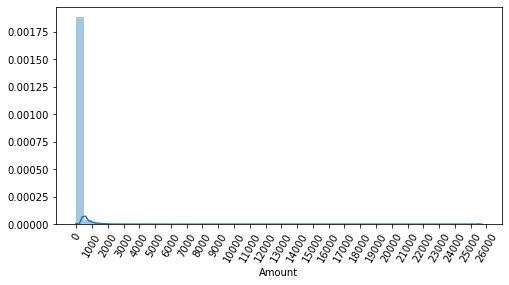

In [9]:
# Amount피처의 분포도 확인
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

카드 사용금액이 1000불 이하인 데이터가 대부분이며, 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가진다. 이를 다음과 같은 과정을 거칠 것이다.
1. 표준 정규 분포 형태로 변환
2. Logistic Regression의 예측 성능 측정

## StandScaler 변환

In [10]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로Amount 피처값 변환하는 로직으로 앞서 만든 get_processed_df()변형
def get_preprocessed_df(df=None):
    df_copy= df.copy()
    scaler= StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [11]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test= get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능###
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율 : 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율 : 0.7568, F1: 0.8421, AUC:0.9773


정규분포형태로 Amount피처값을 변환 한 후 테스트 데이터 셋에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았다. 이번엔 로그 변환을 수행해 볼 것이다. 이는 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나이다. 원래값을 log값으로 변환하여 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해준다.

## Log변환

In [12]:
def get_preprocessed_df(df=None):
    df_copy= df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy 

In [13]:
# Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test= get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능###
오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율 : 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율 : 0.7635, F1: 0.8496, AUC:0.9786


두 모델 모두 정밀도, 재현율, ROCㅡAUC에서 약간씩 성능이 개선되었다.

## outlier detection 
![](https://www.mathsisfun.com/data/images/interquartile-range.svg)
IQR을 이용해 이상치를 검출하는 방식은 보통 IQR * 1.5를 해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는것이다.

(보통 1.5값 사용)
* Q3 + (IQR * 1.5 ) => 최댓값 
* Q1 - (IQR * 1.5 ) => 최솟값 

![](https://lh3.googleusercontent.com/proxy/41QwTEfSb8QDYWpS58urkfP10acwsgjGWCX9B9Gjr4SbuXRJ3xvRUEveUYPoHzWuI9JBcrbAlHy7XRNT17PyQ60YCsX4fXHM_BZLZqJlITG9oFcC5fuSarm4cC3XoSJ0dba33nogrwBUg06UnUm52l27UmyDe6LYbOi6rBwuee8vbZeKjQIV_zlwLXtbmJwE-dLbDvhI-o3hJg)

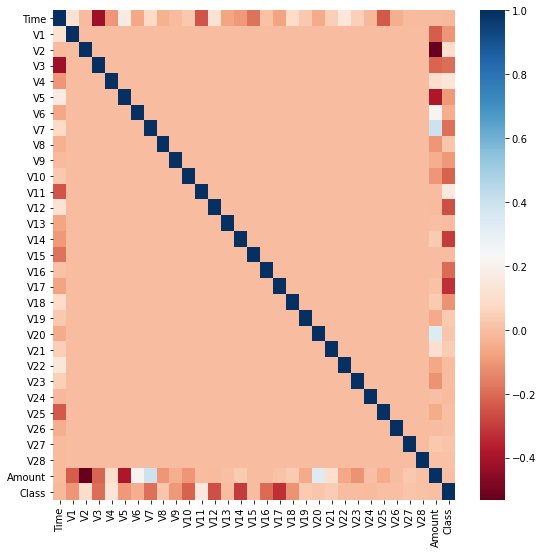

In [14]:
# 이상치 데이터를 IQR이용하여 제거
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu') # cmap='RdBu'로 하면 +상관관계높을수록 진한 파랑, -상관관계높을수록 진한 빨간색

Clss피처와 음의 상관관계가 가장 높은 V14와 V17 중 V14에 대해서만 이상치를 찾아 제거하도록 한다. 
1. IQR을 이용하여 이상치를 검출하는 함수 생성
2. 이를 이용해 검출된 이상치 삭제

In [15]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, Q1과 Q3지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud<lowest_val) | (fraud>highest_val)].index # pandas에서는 ||,&& 가 아니고 |, &라고한다.
    return outlier_index

In [16]:
# V14 칼럼에서 이상치 데이터 찾기
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


4개의 데이터가 이상치로 추출됨. 이를 삭제하는 로직을 get_processed_df()함수에 추가해 데이터를 가공한 뒤 이 데이터 셋을 이용해서 로지스틱 회귀와 LightGBM모델을 다시 적용해보겠다.

In [27]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [28]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율 : 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율 : 0.8288, F1: 0.8930, AUC:0.9831


이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM모두 재현율이 크게 향상되었다.

* 로지스틱 회귀의 재현율 : 60.81% -> 67.12%
* LightGBM의 재현율 : 76.35% -> 82.88%

## SMOTE over sampling

imbalanced-learn 패키지의 SMOTE클래스를 이용해서 구현 가능하다. 반드시 "**학습**"데이터 셋에만 오버 샘플링 해야함을 주의하자. 앞에서 생성한 학습 피처/레이블 데이터를 SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤 증식 전과 비교해 본다.

### 1. logistic regression

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 셋: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 셋: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 셋:  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 셋:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


SMOTE적용 전 학습 데이터 셋은 199,364건 -> 적용 후 2배에 가까운 398,040건으로 증식되었다. 또, 적용 후 레이블 값인 0과 1분포가 동일하게 생성되었다. 이 학습 데이터 셋을 기반으로 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해보겠다.

In [20]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의!
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[83317  1978]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0630, 재현율 : 0.8986, F1: 0.1178, AUC:0.9803


로지스틱 회귀모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습하면 재현율은 0.6->0.8로 크게 증가하지만 반대로 정밀도가 0.8->0.06으로 급격히 저하되었다.
> 재현율이 높더라도 이정도로 저조한 정밀도는 현실 업무에 적용할 수 없다.

**왜 이런 현상이 발생할까?**

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 셋에서 예측을 지나치게 Class=1로 적용해서 정밀도가 급격히 떨어진 것이다. 분류 결정 임계값(threshold)에 따른 정밀도와 재현율 곡선을 통해서 어떤 문제가 발생하고 있는지 시각화 해보도록 한다. **precision_recall_curve_plot()**함수를 이용할 것이다. 

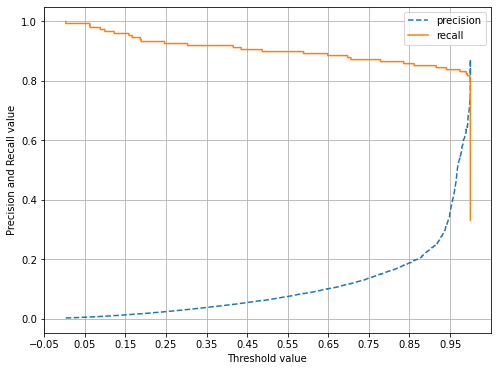

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    # x축, y축 label과 legend,grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

보다시피 임계값의 민감도가 너무 심해서 올바른 재현율/정밀도 성능을 얻을 수 없다. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 셋으로 학습/예측/평가를 수행하도록 한다.

### 2. LightGBM

In [22]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[85284    11]
 [   32   116]]
정확도: 0.9995, 정밀도: 0.9134, 재현율 : 0.7838, F1: 0.8436, AUC:0.9855


재현율은 높아졌으나, 정밀도는 낮아졌다. 하지만 일반적인 현상이다. 좋은 SMOTE패키지일수록 재현율의 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.